In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [72]:
train = pd.read_csv("train_without_error.csv")
test = pd.read_csv("test_without_error.csv")

In [73]:
train.shape, test.shape

((2869, 15), (1008, 14))

In [74]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [75]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [76]:
# 임대보증금 피처 전처리

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [77]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [78]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [79]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

# 임대보증금이 0인 값을 -> 학습 셋의 중앙값으로 치환

train_df.loc[train_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()
test_df.loc[test_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

In [80]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [81]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [82]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

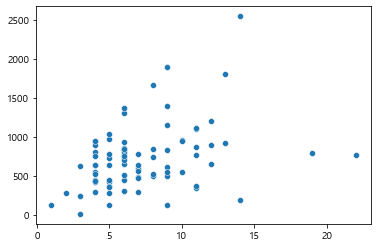

In [83]:
area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [84]:
# # 지역별 인구수 컬럼 추가
# population_df = pd.read_csv("../data/dacon_parking_demand_dataset/age_gender_info.csv")

# train_df = pd.merge(train_df, population_df, on="지역")
# test_df = pd.merge(test_df, population_df, on="지역")

In [85]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [86]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [87]:
# 전용 면적 피처를 5의 배수로 전처리

train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [88]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [89]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [90]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

<AxesSubplot:xlabel='임대료', ylabel='전용면적 당 차량등록수'>

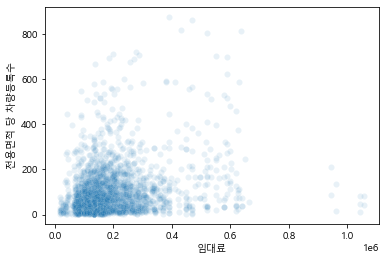

In [93]:
# 임대료 처리

train_df.loc[train_df[train_df["임대료"] == "-"].index, "임대료"] = 0
train_df["임대료"] = train_df["임대료"].fillna(0)
train_df["임대료"] = train_df["임대료"].astype(int)
train_df.loc[train_df["임대료"] == 0, "임대료"] = train_df["임대료"].median()

test_df.loc[test_df[test_df["임대료"] == "-"].index, "임대료"] = 0
test_df["임대료"] = test_df["임대료"].fillna(0)
test_df["임대료"] = test_df["임대료"].astype(int)
test_df.loc[test_df["임대료"] == 0, "임대료"] = train_df["임대료"].median()

# sns.scatterplot(data=train_df, x="임대료", y="전용면적 당 차량등록수", alpha=0.1)

In [103]:
# X_train & X_test 셋 선택

X_train_df_sel = train_df.drop(["지역", "공급유형", "전용면적", "자격유형", "실거주세대수", 
                                "단지내주차면수", "등록차량수", "전용면적 당 차량등록수"], axis=1)

X_test_df_sel = test_df.drop(["지역", "공급유형", "전용면적", "자격유형", "실거주세대수", 
                              "단지내주차면수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [104]:
X_train_df_sel.columns

Index(['단지코드', '총세대수', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', '세대수비율주차면수',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가',
       '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적'],
      dtype='object')

In [105]:
X_test_df_sel.columns

Index(['단지코드', '총세대수', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', 'A', 'C', 'D',
       'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'B', 'F', 'O', '세대수비율주차면수',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가',
       '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적'],
      dtype='object')

In [106]:
# X_test_df_sel의 컬럼 순서 X_train_df_sel과 동일하게 정렬해주기

column_names = ['단지코드', '총세대수', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', '세대수비율주차면수',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가',
       '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['단지코드', '총세대수', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', '세대수비율주차면수',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가',
       '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적'],
      dtype='object')

In [107]:
len(X_train_df_sel.columns), len(X_test_df_sel.columns)

(43, 43)

In [108]:
X_train_df_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   전용면적별세대수                      2869 non-null   int64  
 3   공가수                           2869 non-null   float64
 4   임대보증금                         2869 non-null   float64
 5   임대료                           2869 non-null   float64
 6   도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 7   도보 10분거리 내 버스정류장 수            2869 non-null   float64
 8   A                             2869 non-null   uint8  
 9   B                             2869 non-null   uint8  
 10  C                             2869 non-null   uint8  
 11  D                             2869 non-null   uint8  
 12  E                             2869 non-null   uint8  
 13  F  

In [120]:
X_train_df_sel.corr().sort_values(by="단지별 총 전용면적", ascending=False)

,총세대수,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,...,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적
단지별 총 전용면적,0.850075,0.200893,0.088688,0.156169,0.264381,0.130329,0.045723,-0.004621,-0.021834,-0.027333,...,-0.071712,-0.084408,-0.097932,-0.134059,-0.157570,-0.056335,0.049114,-0.049114,0.255220,1.000000
총세대수,1.000000,0.100724,0.072371,-0.016905,-0.034593,0.211580,-0.002216,-0.342674,-0.032767,0.066346,...,-0.082866,-0.113225,-0.109258,-0.113241,-0.110097,-0.087397,0.340725,-0.340725,0.044899,0.850075
임대료,-0.034593,0.027333,-0.091726,0.527362,1.000000,0.046442,0.051145,0.296615,-0.029899,-0.126693,...,0.041135,-0.094118,-0.077679,-0.044251,-0.110795,-0.034488,-0.195315,0.195315,0.201270,0.264381
세대수 규모 당 총 전용면적,0.044899,0.916059,0.136399,0.105688,0.201270,-0.061043,0.055822,0.271950,-0.004364,0.146185,...,0.018029,-0.002070,0.016231,-0.043062,-0.074201,0.037115,-0.383515,0.383515,1.000000,0.255220
부산광역시,0.433359,-0.039754,0.026010,-0.096478,-0.077276,0.312631,-0.169366,-0.279061,-0.030851,0.068191,...,-0.039346,-0.083493,-0.071399,-0.065026,-0.086736,-0.088179,0.429858,-0.429858,-0.064161,0.250273
세대수비율주차면수,0.038311,0.846098,0.239568,0.096988,0.176675,-0.081998,0.055491,0.299187,0.000273,-0.032671,...,0.016470,-0.003067,0.013166,-0.036019,-0.102523,0.065619,-0.402039,0.402039,0.905712,0.239889
대전광역시,0.245565,-0.017487,-0.044192,-0.060892,-0.066232,0.229665,0.120011,-0.125997,-0.027450,0.095320,...,-0.035008,-0.074288,-0.063528,-0.057857,-0.077173,-0.078457,0.184389,-0.184389,-0.027746,0.208734
세종특별자치시,0.081431,0.049887,-0.037984,0.077515,0.207048,-0.036955,-0.058679,0.074579,-0.007887,-0.016997,...,-0.010058,-0.021344,-0.018253,-0.016623,-0.022173,-0.022542,-0.045332,0.045332,0.075368,0.206583
전용면적별세대수,0.100724,1.000000,0.162760,-0.019452,0.027333,-0.048144,0.045899,0.153130,-0.005790,0.284550,...,0.010253,-0.013522,0.009573,-0.032173,-0.064649,0.026540,-0.376661,0.376661,0.916059,0.200893
경기도,0.075522,0.049567,-0.004027,0.247819,0.215841,0.050489,0.124892,0.072774,0.016589,-0.094661,...,-0.056018,-0.118872,-0.101653,-0.092580,-0.123489,-0.125543,-0.252469,0.252469,0.053676,0.156746


In [123]:
X_train_code_name = X_train_df_sel["단지코드"]
X_test_code_name = X_test_df_sel["단지코드"]

In [124]:
X_train_df_sel = X_train_df_sel.drop("단지코드", axis=1)
X_test_df_sel = X_test_df_sel.drop("단지코드", axis=1)

X_train_df_sel = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_sel = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df = y_train_df.apply(lambda x: np.log1p(x))

In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_df_sel)

X_train_df_scaled = scaler.transform(X_train_df_sel)
X_test_df_scaled = scaler.transform(X_test_df_sel)
X_test_df_scaled[:5]

array([[ 0.02416506,  0.63707819,  0.46686797,  0.20777201,  0.38355136,
        -0.41717302, -0.74183078, -1.23153021, -0.08586964, -0.1850583 ,
        -0.49738446, -0.11430211, -0.03235359, -0.05609682,  4.18445665,
        -0.13181763, -0.19297121, -0.10787079, -0.10787079, -0.02641199,
        -0.10279641, -0.01867284,  0.68642306, -0.26405319,  1.95495492,
        -0.38059474, -0.20061544, -0.22734603, -0.19199747, -0.31967136,
        -0.35928128, -0.0918469 , -0.10951231, -0.23238849, -0.19872784,
        -0.18099   , -0.24141474, -0.24543128, -0.49356501,  0.49356501,
         0.55964121,  0.36762286],
       [ 0.02416506, -0.12746994,  0.46686797,  1.01944159,  0.90614136,
        -0.41717302, -0.74183078,  0.81199794, -0.08586964, -0.1850583 ,
        -0.49738446, -0.11430211, -0.03235359, -0.05609682, -0.23897965,
        -0.13181763, -0.19297121, -0.10787079, -0.10787079, -0.02641199,
        -0.10279641, -0.01867284, -0.0316859 , -0.26405319,  1.95495492,
        -0.38059

### XGBoost & LightGBM & RandomForestRegressor 모델 평가

In [129]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [137]:
from sklearn.model_selection import cross_val_score

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

score = cross_val_score(rf_reg, X_train_df_scaled, y_train_df, cv=5, scoring="neg_mean_absolute_error")
average_score = np.abs(score.mean())
print("RandomForestRegressor Score: {:.4f}".format(average_score))

RandomForestRegressor Score: 0.2059


In [138]:
score = cross_val_score(xgb_reg, X_train_df_scaled, y_train_df, cv=5, scoring="neg_mean_absolute_error")
average_score = np.abs(score.mean())
print("XGBoost Score: {:.4f}".format(average_score))

XGBoost Score: 0.2228


In [139]:
score = cross_val_score(lgbm_reg, X_train_df_scaled, y_train_df, cv=5, scoring="neg_mean_absolute_error")
average_score = np.abs(score.mean())
print("LightGBM Score: {:.4f}".format(average_score))

LightGBM Score: 0.2062


### RandomForestRegressor 기본 모델 예측 점수 (106.9012715804)

In [145]:
sub = pd.read_csv("../data/dacon_parking_demand_dataset/test.csv")

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_reg.fit(X_train_df_scaled, y_train_df)
pred = rf_reg.predict(X_test_df_scaled)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df.to_csv("rf_regressor_with_임대료추가_실거주세대수제거_log1p_StandardScaler_0721.csv", index=False)

sub_df

,code,num
0,C1072,790.822604
1,C1128,1360.003555
2,C1456,530.027314
3,C1840,451.117467
4,C1332,1215.586645
...,...,...
145,C2456,249.624276
146,C1266,397.752433
147,C2152,39.397350
148,C1267,374.702578


In [179]:
# # 전처리 완료된 데이터 셋 csv 파일로 추출

# X_train_df_sel.to_csv("X_train_df.csv", index=False)
# X_test_df_sel.to_csv("X_test_df.csv", index=False)
# y_train_df.to_csv("y_train_df.csv", index=False)